In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm

pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_key_collector import keys_df, symbol, h5_name, available_dates
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()


contracts data available for SPY:
0       2024-10-11
1       2024-10-10
2       2024-10-09
3       2024-10-08
4       2024-10-07
           ...    
2254    2015-10-22
2255    2015-10-21
2256    2015-10-20
2257           NaN
2258           NaN
Name: 0, Length: 2259, dtype: object

                   raw_data_key               surface_key  \
0     /date_2024_10_11/raw_data  /date_2024_10_11/surface   
1     /date_2024_10_10/raw_data  /date_2024_10_10/surface   
2     /date_2024_10_09/raw_data  /date_2024_10_09/surface   
3     /date_2024_10_08/raw_data  /date_2024_10_08/surface   
4     /date_2024_10_07/raw_data  /date_2024_10_07/surface   
...                         ...                       ...   
2252  /date_2015_10_26/raw_data                       NaN   
2253  /date_2015_10_23/raw_data                       NaN   
2254  /date_2015_10_22/raw_data                       NaN   
2255  /date_2015_10_21/raw_data                       NaN   
2256  /date_2015_10_20/raw_data                

# available time-series

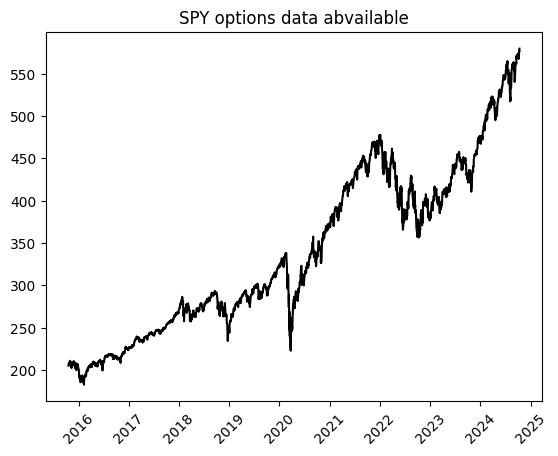

<Figure size 640x480 with 0 Axes>

In [2]:
spot_keys = keys_df.loc[:,['spot_price','date']].dropna()
spots = pd.Series(np.zeros(len(spot_keys)),index=spot_keys['date'])
spots.index = [datetime.strptime(date, '%Y-%m-%d') for date in spots.index.tolist()]
store.open()
for i,row in spot_keys.iterrows():
    spot_price = float(store[row['spot_price']].iloc[0])
    date = row['date']
    spots[date] = spot_price
store.close()
plt.figure()
plt.plot(spots,color='black')
plt.xticks(rotation=45)
plt.title(symbol + ' options data available')
plt.show()
plt.clf()

# volatility surface query

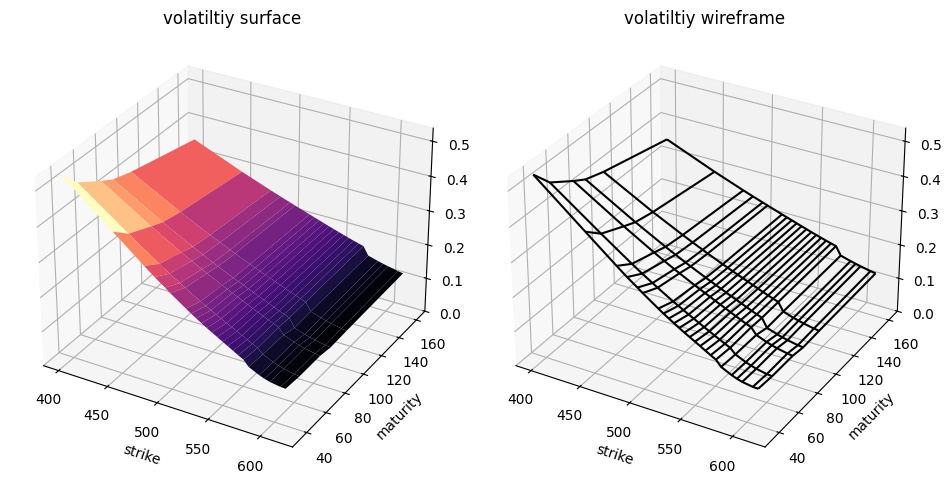

<Figure size 640x480 with 0 Axes>

In [3]:
from historical_av_plot_vol_surface import plot_vol_surface
surface_keys = keys_df.dropna(subset='surface_key').iloc[:1]
while True:
    try:
        store.open()
        surface = store[surface_keys.iloc[0]['surface_key']]
        break
    except OSError:
        time.sleep(2)
    finally:
        store.close()

plot_vol_surface(surface)

# calibrations

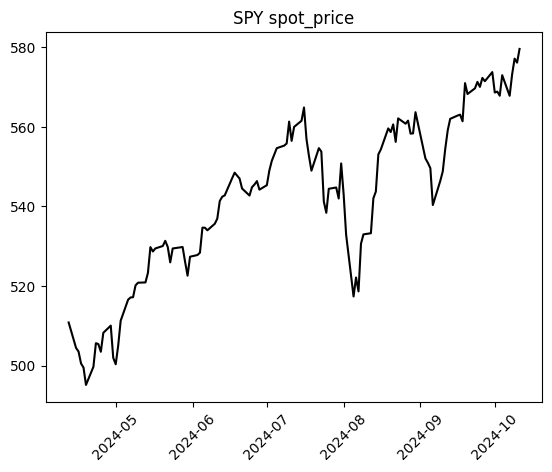

<Figure size 640x480 with 0 Axes>

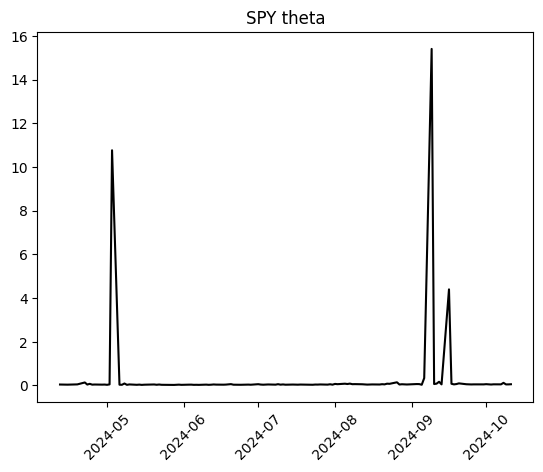

<Figure size 640x480 with 0 Axes>

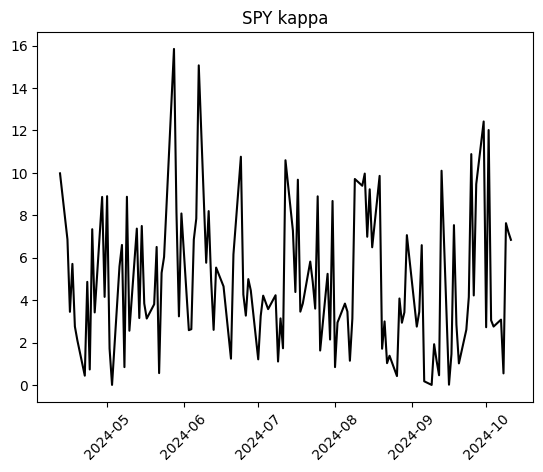

<Figure size 640x480 with 0 Axes>

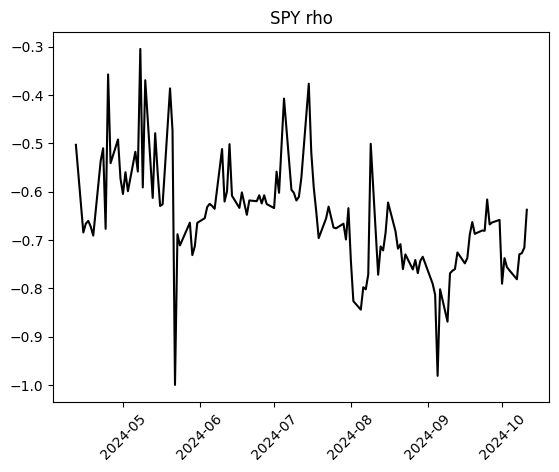

<Figure size 640x480 with 0 Axes>

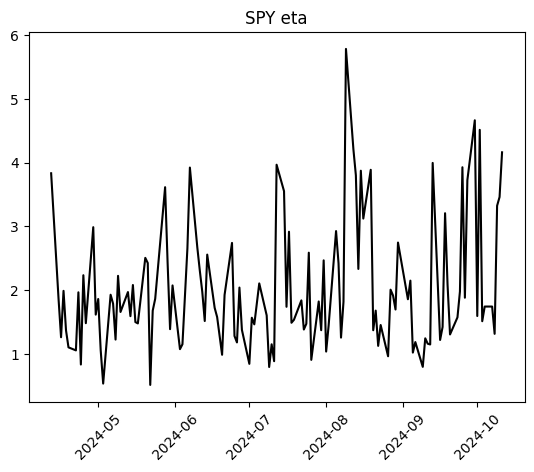

<Figure size 640x480 with 0 Axes>

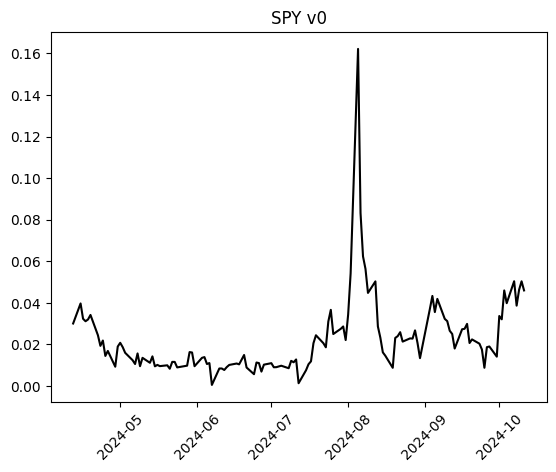


                    calculation_date  strike_price  market_price  \
count                         316716 316716.000000 316716.000000   
mean   2024-07-14 09:37:26.095555584    479.544248     42.256766   
min              2024-04-12 00:00:00    120.000000      0.000000   
25%              2024-05-29 00:00:00    405.000000      0.140000   
50%              2024-07-18 00:00:00    495.000000      4.950000   
75%              2024-08-27 00:00:00    557.000000     45.440000   
max              2024-10-11 00:00:00    830.000000    461.370000   
std                              NaN    123.750906     75.699477   

         volatility  days_to_maturity    spot_price  risk_free_rate  \
count 316716.000000     316716.000000 316716.000000   316716.000000   
mean       0.224898        105.699813    542.476777        0.040000   
min        0.007030         30.000000    495.160000        0.040000   
25%        0.127910         50.000000    528.690000        0.040000   
50%        0.176840         84.

<Figure size 640x480 with 0 Axes>

In [6]:
calibration_keys = keys_df.copy().dropna(subset=['calibration_key','parameter_key'])
calibrations = []
parameters = {}
while True:
    try:
        store.open()
        for i,row in calibration_keys.iterrows():
            calibrations.append(store[row['calibration_key']])
            parameters[row['date']] = store[row['parameter_key']]
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True).dropna(subset='strike_price')
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date')
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()

for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(symbol + ' ' + col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

In [5]:
calibrations

,strike_price,w,market_price,volatility,days_to_maturity,calculation_date,spot_price,risk_free_rate,dividend_rate,theta,kappa,eta,rho,v0,moneyness,black_scholes,heston_price,error
0,260.000000,call,320.910000,0.245830,35,2024-10-11,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.229154,320.575350,320.594510,0.019159
1,260.000000,put,0.040000,0.868900,35,2024-10-11,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.551399,0.040439,0.019159,-0.021280
2,265.000000,call,308.750000,0.241990,35,2024-10-11,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.187094,315.594492,315.616372,0.021880
3,265.000000,put,0.040000,0.849380,35,2024-10-11,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.542772,0.040437,0.021880,-0.018556
4,270.000000,call,303.990000,0.238140,35,2024-10-11,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.146593,310.613633,310.638560,0.024927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316711,690.000000,put,255.250000,0.442380,161,2024-04-12,510.850000,0.040000,0.000000,0.043812,9.977074,3.833370,-0.503407,0.030067,0.350690,182.424352,167.505461,-14.918892
316712,695.000000,call,0.050000,0.151080,161,2024-04-12,510.850000,0.040000,0.000000,0.043812,9.977074,3.833370,-0.503407,0.030067,-0.264964,0.032951,0.393840,0.360889
316713,695.000000,put,260.320000,0.450310,161,2024-04-12,510.850000,0.040000,0.000000,0.043812,9.977074,3.833370,-0.503407,0.030067,0.360478,187.454138,172.388919,-15.065219
316714,700.000000,call,0.030000,0.154430,161,2024-04-12,510.850000,0.040000,0.000000,0.043812,9.977074,3.833370,-0.503407,0.030067,-0.270214,0.032979,0.367139,0.334160
